# PySCNet: A tool for reconstructing and analyzing gene regulatory network from single-cell RNA-Seq data

PySCNet includes four modules:

1) **Pro-precessing**: initialize a gnetData object consisting of Expression Matrix, Cell Attributes, Gene Attributes and Network Attributes; <br/>
2) **BuildNet**: reconstruct GRNs by various methods implemented in docker;<br/>
3) **NetEnrich**: network analysis including consensus network detection, gene module identification and trigger path prediction as well as network fusion;<br/>
4) **Visulization**: network illustration.<br/>

A python package - [STREAM](https://github.com/pinellolab/STREAM) was designed for reconstructing cell trajectory for single cell transcriptomic data. This tutorial guides how to integrate STREAM with pyscnet for gene regulatory network along the cell differential trajectory.


In [12]:
from __future__ import absolute_import
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import itertools
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

from pyvis.network import Network
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt 
from pyscnet.Preprocessing import gnetdata
from pyscnet.BuildNet import gne_dockercaller as gdocker
from pyscnet.BuildNet import gne_synchrony as gs
from pyscnet.NetEnrich import graph_toolkit as gt
from pyscnet.Plotting import show_net as sn
from pyscnet.Plotting import geneHeatmap as gh
pd.set_option('display.max_rows', 1000)

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.23.2 statsmodels==0.11.1


### Data resource
Data was obtained from [Nestorowa, S. et al](https://doi.org/10.1182/blood-2016-05-716480). The cell trajectory was build according to [STREAM Tutorial](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/1.1.STREAM_scRNA-seq%20%28Bifurcation%29.ipynb?flush_cache=true). As STREAM is also built on AnnData structure, it can be directly imported into pyscnet.

In [2]:
#the file is too large
# import _pickle as pk
# with open('data/stream_adata.pk', 'rb') as input:
#     adata = pk.load(input)
#user jupyter-notebook in stream env: ~/miniconda3/envs/stream/bin/
import stream as st
adata = st.read('data/stream_adata.pklz')


Working directory is already specified as './result' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


As explained in [STREAM Tutorial](https://nbviewer.jupyter.org/github/pinellolab/STREAM/blob/master/tutorial/1.1.STREAM_scRNA-seq%20%28Bifurcation%29.ipynb?flush_cache=true), new attributes including cell pseudotime at different branches are added into **obs** of AnnData. It gives us the hints of ordering cells by pseudotime and estimating gene dynamics along cell trajectory.

In [3]:
adata.var_names

Index(['Gm28070', 'Gm16322', 'Gm8495', 'Igkv3-11', 'Gm22363', 'Gcfc2',
       'Gm24592', 'Rho', 'Gm25111', 'Slco2a1',
       ...
       'Impact', 'Dsg3', 'Fam13b', 'Rprd1a', 'Taf4b', 'Zfp521', 'Hrh4', 'Dsc1',
       'Psma8', '2700062C07Rik'],
      dtype='object', length=35077)

### Cell trajectories built by stream
As shown below, 6 cell sub-populations form a Bifurcation trajectory starting from HSC expanding into two directions. One is MEP branch and the other one is GMP branch. Additionally, leaf markers and transition markers are detected for each branch. It guides us for feature selection

In [4]:
st.plot_stream_sc(adata,root='S3',color=['label'], plotly=True,
                  dist_scale=0.1,show_graph=True,show_text=True)

In [5]:
#leaf_markers of cell pathway: S1 -> S2
adata.uns['leaf_markers'][('S1','S2')].head()

zscore H_statistic      H_pvalue   S3S1_pvalue S1S2_pvalue  \
Mfsd2b  1.41257     938.321  1.76265e-204  2.78863e-209           1   
Lcp1   -1.41168     838.086  1.02799e-182  1.04374e-144           1   
Aqp1    1.41421     830.173  5.37295e-181  7.15629e-161           1   
Gata1   1.41361     829.465  7.65578e-181  1.96117e-162           1   
Klf1    1.41378     801.407  9.47857e-175  2.91898e-158           1   

         S1S0_pvalue  
Mfsd2b  5.62722e-271  
Lcp1    7.64013e-242  
Aqp1    5.32332e-230  
Gata1   9.52239e-229  
Klf1    5.26742e-215

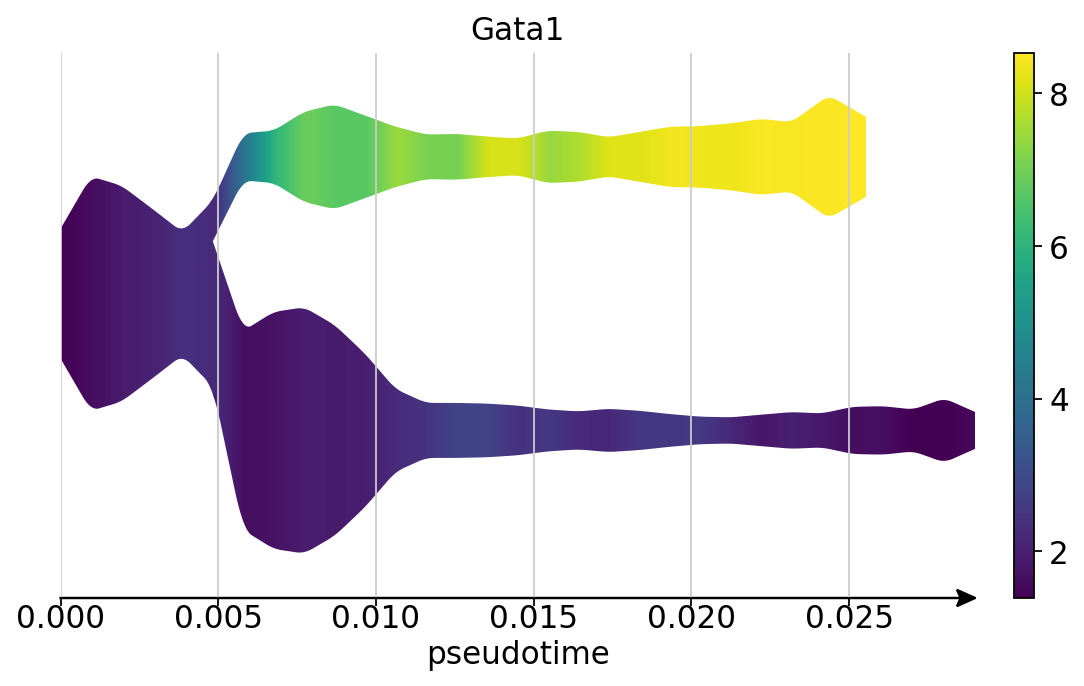

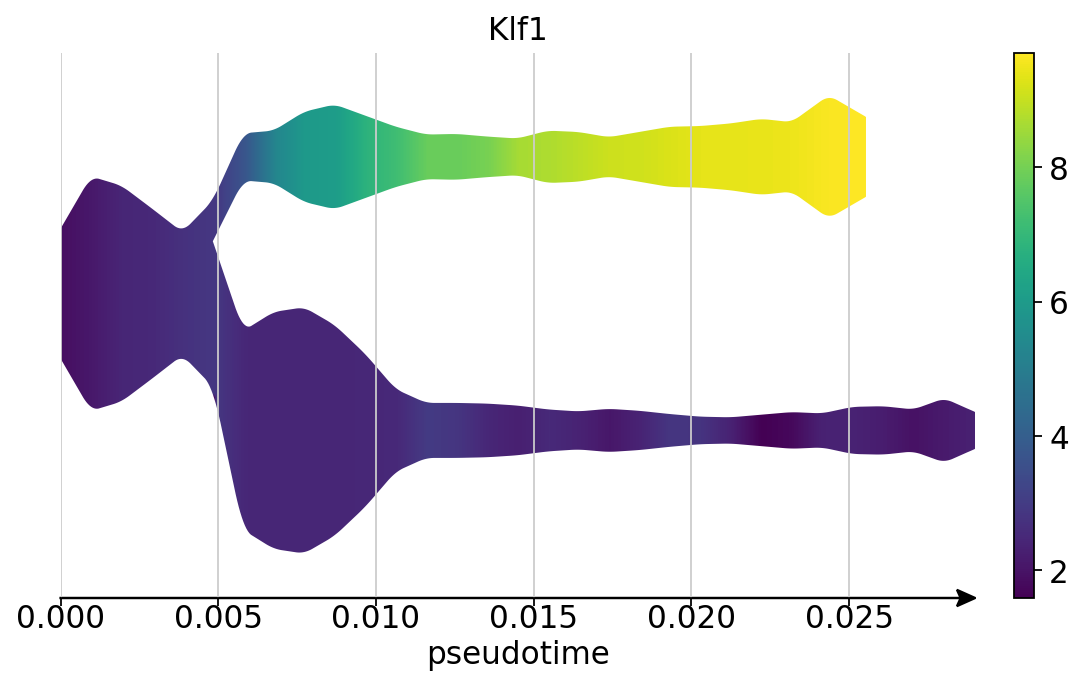

In [6]:
st.plot_stream(adata,root='S3',color=['Gata1','Klf1'])

In [7]:
#Import stream anndata into pyscnet
stream_gne = gnetdata.load_from_scanpy(adata)

### Select trajectory branch and Features for GRN:
In the following, cells from **S1** to **S2** and **positive leaf markers** of (S1->S2) will be selected for GRN construction. As shown below, positive leaf markers are only highly expressed in cells of S1 -> S2. There are 236 genes and 535 cells selected for downstream analysis. 


<!-- As reported in [this publication](https://www.pnas.org/content/114/23/5822), GRNs specific for **MEP (S1->S2)** and **LMPP(S1->S3)** were built based on pre-selected 31 features. In the following, cells from above branches will be individually tested for gene correlation.  -->
<!-- Features_Paper = ['Bptf', 'Cbfa2t3', 'Erg', 'Ets1', 'Ets2', 'Etv6', 'Fli1', 'Gata1', 'Gata2', 'Gata3', 'Gfi1b', 'Hhex',
           'Hoxa5', 'Hoxa9', 'Hoxb4', 'Ikzf1', 'Ldb1', 'Lmo2', 'Lyl1', 'Meis1', 'Mitf', 'Myb', 'Nfe2', 'Nkx2-3',
           'Notch1', 'Pbx1', 'Prdm16', 'Runx1', 'Smarcc1', 'Tal1', 'Tcf7']

# list(filter(lambda x:'Not' in x, stream_gne.ExpMatrix.index))
# [gene in stream_gne.ExpMatrix.index for gene in Features_Paper] -->

In [8]:
#select cells from S1 -> S2
cell_info = stream_gne.CellAttrs['CellInfo'].sort_values('S1_pseudotime', ascending=True)
cell = list(cell_info.loc[cell_info['branch_id_alias'].isin([('S2', 'S1')])].index)
len(cell)

535

In [9]:
#select positive leaf markers 
feature = adata.uns['leaf_markers'][('S1', 'S2')]
# feature = feature.sort_values('zscore', ascending=False).head(100).index
feature = feature[feature.zscore > 0].index

# with open('result/S0_S1_leafMarker.txt', 'w') as file:
#     file.writelines(["%s\n" % item for item in feature])


### Remove isolated nodes:
In order to evaluate the performance of different GRN methods, reference linkage was download from [string PPI](https://string-db.org/) filtered by **high confidence score > 0.7** and **PPI enrichment p-value < 1.0e-16**. There are 420 edges left among the 117 features. 119 isolated ndoes without connecting to any others were removed for GRN construction.

In [10]:
import networkx as nx
Ref_edges = pd.read_csv('/home/mwu/Downloads/string_interactions_2.tsv', 
                          sep='\t').iloc[:,:2]

Ref_edges.columns = ['source', 'target']
Ref_edges['weight'] = 1

G = nx.from_pandas_edgelist(Ref_edges)
feature = list(set(feature) & set(G.nodes))

len(feature)


117

Text(0.5, 0.98, 'pairwise gene and rolling window correlation')

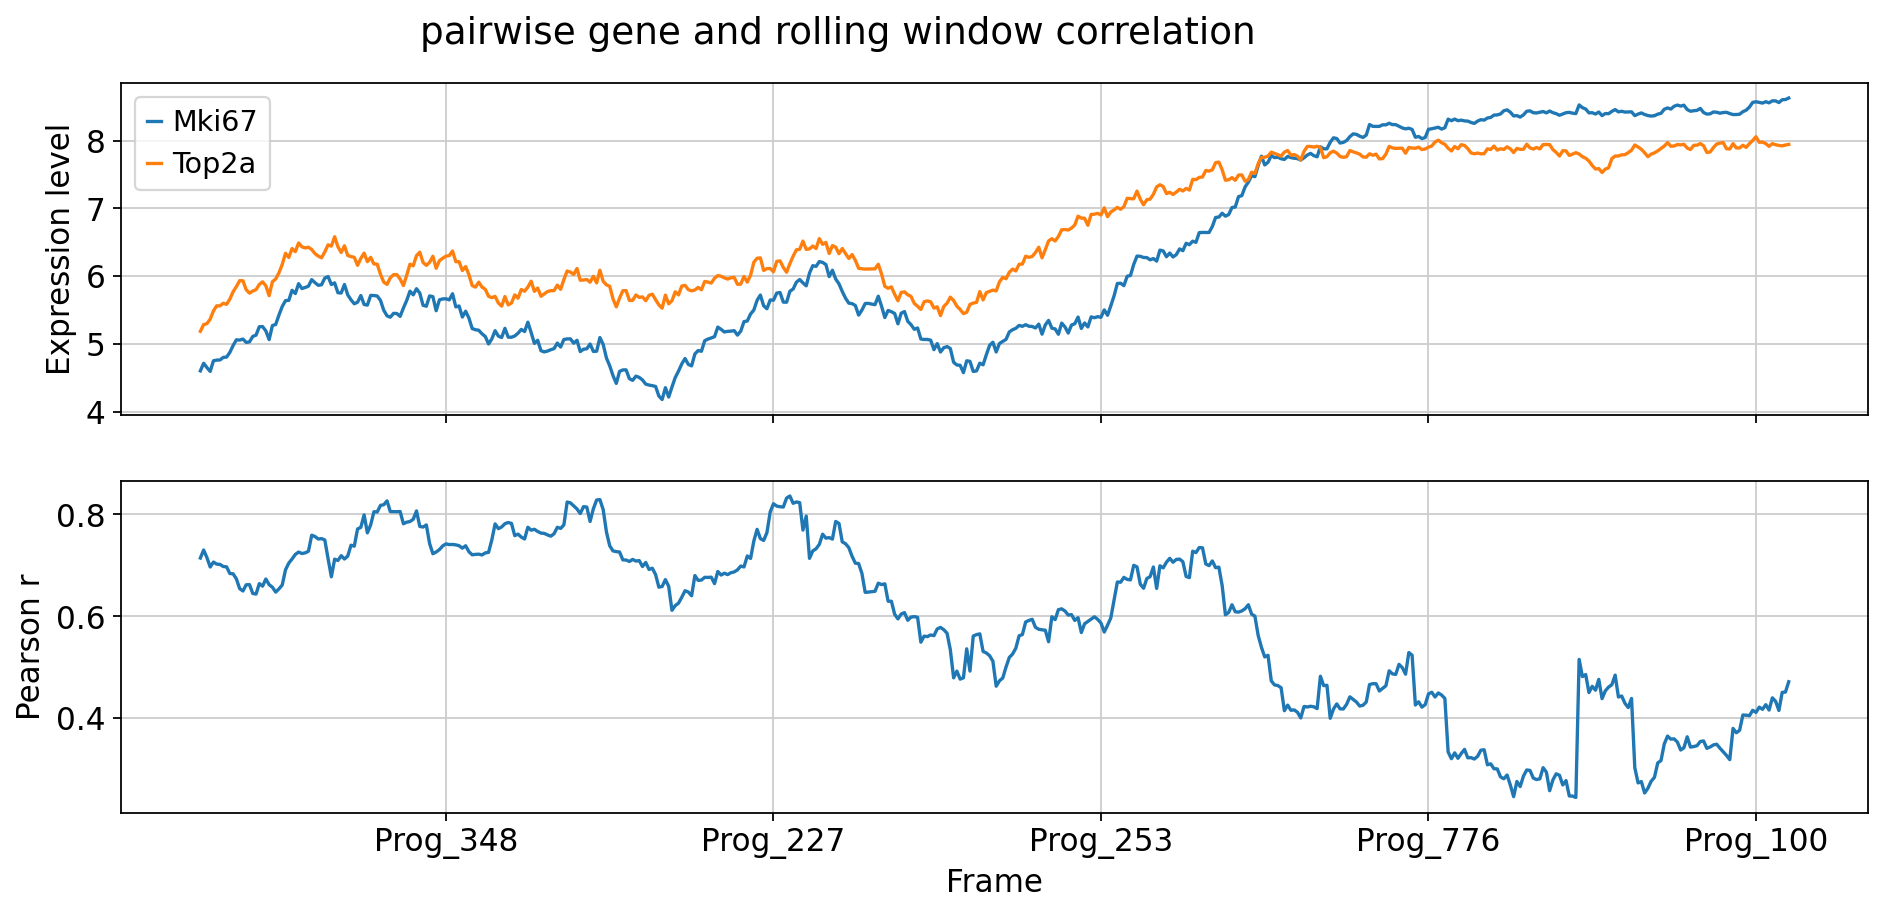

In [13]:
# Set window size to compute moving window synchrony.
r_window_size = 50
subExpr = stream_gne.ExpMatrix.loc[feature, cell]
df = subExpr.T
genes = ['Mki67', 'Top2a']
# Interpolate missing data.
df_interpolated = df.interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated[genes[0]].rolling(window=r_window_size, center=True).corr(df_interpolated[genes[1]])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df[genes].rolling(window=r_window_size,center=True).mean().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Expression level')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("pairwise gene and rolling window correlation")

### BuildNet: Construct GRN by applying popular methods 
As reported in [GRN benchmark paper](https://pubmed.ncbi.nlm.nih.gov/31907445/), although some tools were designed for estimating gene regulatory relationship from transcriptomic data, only three methods ([GENIE3](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012776), [PIDC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624513/) and [GRNBOOST2](https://academic.oup.com/bioinformatics/article-abstract/35/12/2159/5184284?redirectedFrom=fulltext)) were considered as competitive. Besides, two additional methods (**window_rolling** and **phase synchrony**) are also provided in the pyscnet. 



In [14]:
stream_gne = gs.get_synchrony(stream_gne.deepcopy, method='window_rolling',
                               feature=feature, cell=cell)

stream_gne = gs.get_synchrony(stream_gne.deepcopy, method='phase_synchrony',
                               feature=feature, cell=cell)


window_rolling_links added into NetAttrs
phase_synchrony_links added into NetAttrs


In [15]:
#GRNs for MEP branch
stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='GENIE3', directed=False,
                               feature=feature, cell=cell)

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='PIDC', directed=False,
                               feature=feature, cell=cell)

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='CORR', directed=False,
                               feature=feature, cell=cell)

stream_gne = gdocker.rundocker(stream_gne.deepcopy, method='GRNBOOST2', directed=False,
                               feature=feature, cell=cell)

GENIE3_links added into NetAttrs
PIDC_links added into NetAttrs
CORR_links added into NetAttrs
GRNBOOST2_links added into NetAttrs


<!-- ### NetEnrich: Consensus edges and Build graph
pyscnet provides multiple ways of predicting consensus network: 

1) random forest classification; <br/>
2) network intersection; <br/>

Given consensus prediction, top *k* edges are selected for building gene graph. Genes importance can be estimated via node centralities including **Degree, PageRank, Closeness**. Furthermore, gene modules are predicted by applying community detection algorithms.

#find consensus links based on ensemble classification
stream_gne = gt.find_consensus_graph(stream_gne, method='intersection', toprank=5000, threshold=1)

#build graph for consensus links
stream_gne = gt.buildnet(stream_gne, key_links='consensus') -->

<!-- ### Assess confidence of censensus network
Here we applied ensemble classification to train the edges with average weight greater than 1.5. It gives us 130 consensus edges. To quality the confidence of obtained edges, we take the network (112 edges) from the paper as a reference and evaluate the confidence of consensus network. To do so, we select top 112 edges from four GRN methods and consensus edges to calculate ROC and PRC. -->

### Assess confidence of different GRNs
To quality the confidence of GRNs obtained from differen methods, top 420 edges were selected from each methods. ROC and PR curves were ultilized for methods evaluation.

In [16]:
Ref_edges = pd.read_csv('/home/mwu/Downloads/string_interactions_2.tsv', 
                          sep='\t').iloc[:,:2]

Ref_edges.columns = ['source', 'target']
Ref_edges['weight'] = 1
Ref_edges.shape

#remove self-loop edges
index_list=list()
for i in range(Ref_edges.shape[0]):
    if Ref_edges.iloc[i]['source'] == Ref_edges.iloc[i]['target']:
        index_list.append(i)
Ref_edges=Ref_edges.drop(index_list)

#As edges are undirected, the following is to create Full reference links (117*116/2) and then merge with the string links 
from itertools import product, permutations, combinations, combinations_with_replacement
Full_Ref = pd.DataFrame(combinations(set(feature), 2), columns=['source', 'target'])
Full_Ref['weight'] = 0

Ref_edges['name'] = Ref_edges['source'] + '_' + Ref_edges['target']
Full_Ref['name'] = Full_Ref['source']+ '_' + Full_Ref['target']

i = 0
for name in Ref_edges.name:
    tmp = list(name.split('_'))
    
    if name in list(Full_Ref['name']):
        
        
        Full_Ref.loc[Full_Ref.name ==  name, 'weight'] = 1
    
    elif tmp[1] + '_' + tmp[0] in list(Full_Ref['name']):
        
        
        Full_Ref.loc[Full_Ref.name == tmp[1] + '_' + tmp[0], 'weight'] = 1
    
    else:
        i = i +1
        
Full_Ref[Full_Ref.weight == 1].shape

(420, 4)

<!-- #extend reference links by shortest paths
# import networkx as nx
# Tmp = Full_Ref[Full_Ref.weight == 1]
# G = nx.from_pandas_edgelist(Tmp)
# path_len = list()
# for i in range(Full_Ref.shape[0]):
#     if Full_Ref.iloc[i]['source'] in G.nodes and Full_Ref.iloc[i]['target'] in G.nodes:
#         if nx.has_path(G, Full_Ref.iloc[i]['source'], Full_Ref.iloc[i]['target']):
#             path_len.append(nx.shortest_path_length(G, Full_Ref.iloc[i]['source'], Full_Ref.iloc[i]['target']))
#         else:
#             path_len.append(0)
#     else:
#         path_len.append(0)
    

# Full_Ref['path_len'] = path_len
# Full_Ref['weight'] = [1 if x in [1] else 0 for x in Full_Ref.path_len]
# Full_Ref[Full_Ref.weight == 1].shape -->

In [17]:
#map edges and calculate roc score
from sklearn import metrics

def mapping_edges(df_1, df_2, df_1_col_1, df_1_col_2, df_2_col_1, df_2_col_2):
    
    df_1['tmp1'] = df_1[df_1_col_1] + '_' + df_1[df_1_col_2]
    df_2['tmp1'] = df_2[df_2_col_1] + '_' + df_2[df_2_col_2]
    
    df_2['tmp2'] = df_2[df_2_col_2] + '_' + df_2[df_2_col_1]

    return len(set(df_1['tmp1']) & set(df_2['tmp1'])) + len(set(df_1['tmp1']) & set(df_2['tmp2']))


def evaluation(links, Full_Ref):
        
    Detected = links.shape[0]
    Ref_links = Full_Ref[Full_Ref.weight == 1]
    TP = mapping_edges(links, Ref_links, 'source', 'target', 'source', 'target')
    FN = Ref_links.shape[0] - TP
    FP = Detected - TP
    TN = Full_Ref.shape[0] - Ref_links.shape[0] - Detected + TP

    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    FDR = FP / (TN + FP)
    F1_Score = (2 * Precision * Recall) / (Precision + Recall)
    
    print('TP:', TP, '\n', 'FN:', FN, '\n', 'FP:', FP, '\n', 'TN:', TN)
    
    links['name'] = links['source'] + '_' + links['target']
    
    for name in links.name:
        tmp = list(name.split('_'))
        if name in list(Full_Ref['name']):
            Full_Ref.loc[Full_Ref.name ==  name, 'weight_2'] = float(format(float(links.loc[links.name == name, 'weight']), '.2f'))
        
        elif tmp[1] + '_' + tmp[0] in list(Full_Ref['name']):
            Full_Ref.loc[Full_Ref.name == tmp[1] + '_' + tmp[0], 'weight_2'] = float(format(float(links.loc[links.name == name, 'weight']), '.2f'))
    
        else: continue
            
    Full_Ref = Full_Ref.fillna(0)
    auc = metrics.roc_auc_score(np.array(Full_Ref['weight'].abs()), np.array(Full_Ref['weight_2'].abs()))
    fpr, tpr, threshold_1 = metrics.roc_curve(Full_Ref['weight'].abs(), Full_Ref['weight_2'].abs())
    pre, recall, threshold_2 = metrics.precision_recall_curve(Full_Ref['weight'].abs(),
                                                              Full_Ref['weight_2'].abs())
    
    avg_pre_auc = metrics.auc(recall, pre)
    
    return {'fpr' :fpr, 'tpr' :tpr, 'pre': pre, 'recall': recall, 'auc':auc, 
            'avg_pre': avg_pre_auc, 'Precision': Precision, 'Recall' : Recall, 'F1_Score' : F1_Score}


In [18]:
#Create ROC and PR curves

import seaborn as sns
def build_curves(ax, dict_of_algs,curve, filename, colors=None, **kwarg):
    
    names = dict_of_algs.keys()
    
    keywords = ['fpr', 'tpr'] if curve == 'ROC' else ['recall', 'pre']
    fill = 1 if curve == 'ROC' else 0

    colors = sns.color_palette().as_hex() + sns.color_palette('hls', 8).as_hex() if colors is None else colors
    section_dict = {sec : {} for sec in ['fpr_dict', 'tpr_dict', 'auc_dict', 'avgpre_dict']}
    
    for name in names:
        section_dict['fpr_dict'][name] = dict_of_algs[name][keywords[0]]
        section_dict['tpr_dict'][name] = dict_of_algs[name][keywords[1]]
        section_dict['auc_dict'][name] = dict_of_algs[name]['auc']
        section_dict['avgpre_dict'][name] = dict_of_algs[name]['avg_pre']
        
    for i, color in zip(list(section_dict['auc_dict'].keys()), colors):
        ax.plot(section_dict['fpr_dict'][i], section_dict['tpr_dict'][i],
                label='ROC curve {0} (area = {1:0.2f})'.format(i, section_dict['auc_dict'][i]) if curve == 'ROC' else
                'PR curve {0} (area = {1:0.2f})'.format(i, section_dict['avgpre_dict'][i]),
                color=color, **kwarg)
   
    if curve == 'ROC':
        ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate' if curve == 'ROC' else 'Recall', fontsize=20)
    ax.set_ylabel('True Positive Rate' if curve == 'ROC' else 'Precision', fontsize=20)
    ax.legend(loc="lower right")


In [19]:
dict_of_algs = dict()
link_keys = list(filter(lambda x:'_links' in x, stream_gne.NetAttrs.keys()))

for link in link_keys:
    method = link.split('_links')[0]
    top = stream_gne.NetAttrs[link].sort_values('weight', ascending=False).head(420)
    dict_of_algs[method] = evaluation(top, copy.deepcopy(Full_Ref))
    


TP: 126 
 FN: 294 
 FP: 294 
 TN: 6072
TP: 159 
 FN: 261 
 FP: 261 
 TN: 6105
TP: 127 
 FN: 293 
 FP: 293 
 TN: 6073
TP: 128 
 FN: 292 
 FP: 292 
 TN: 6074
TP: 43 
 FN: 377 
 FP: 377 
 TN: 5989
TP: 125 
 FN: 295 
 FP: 295 
 TN: 6071


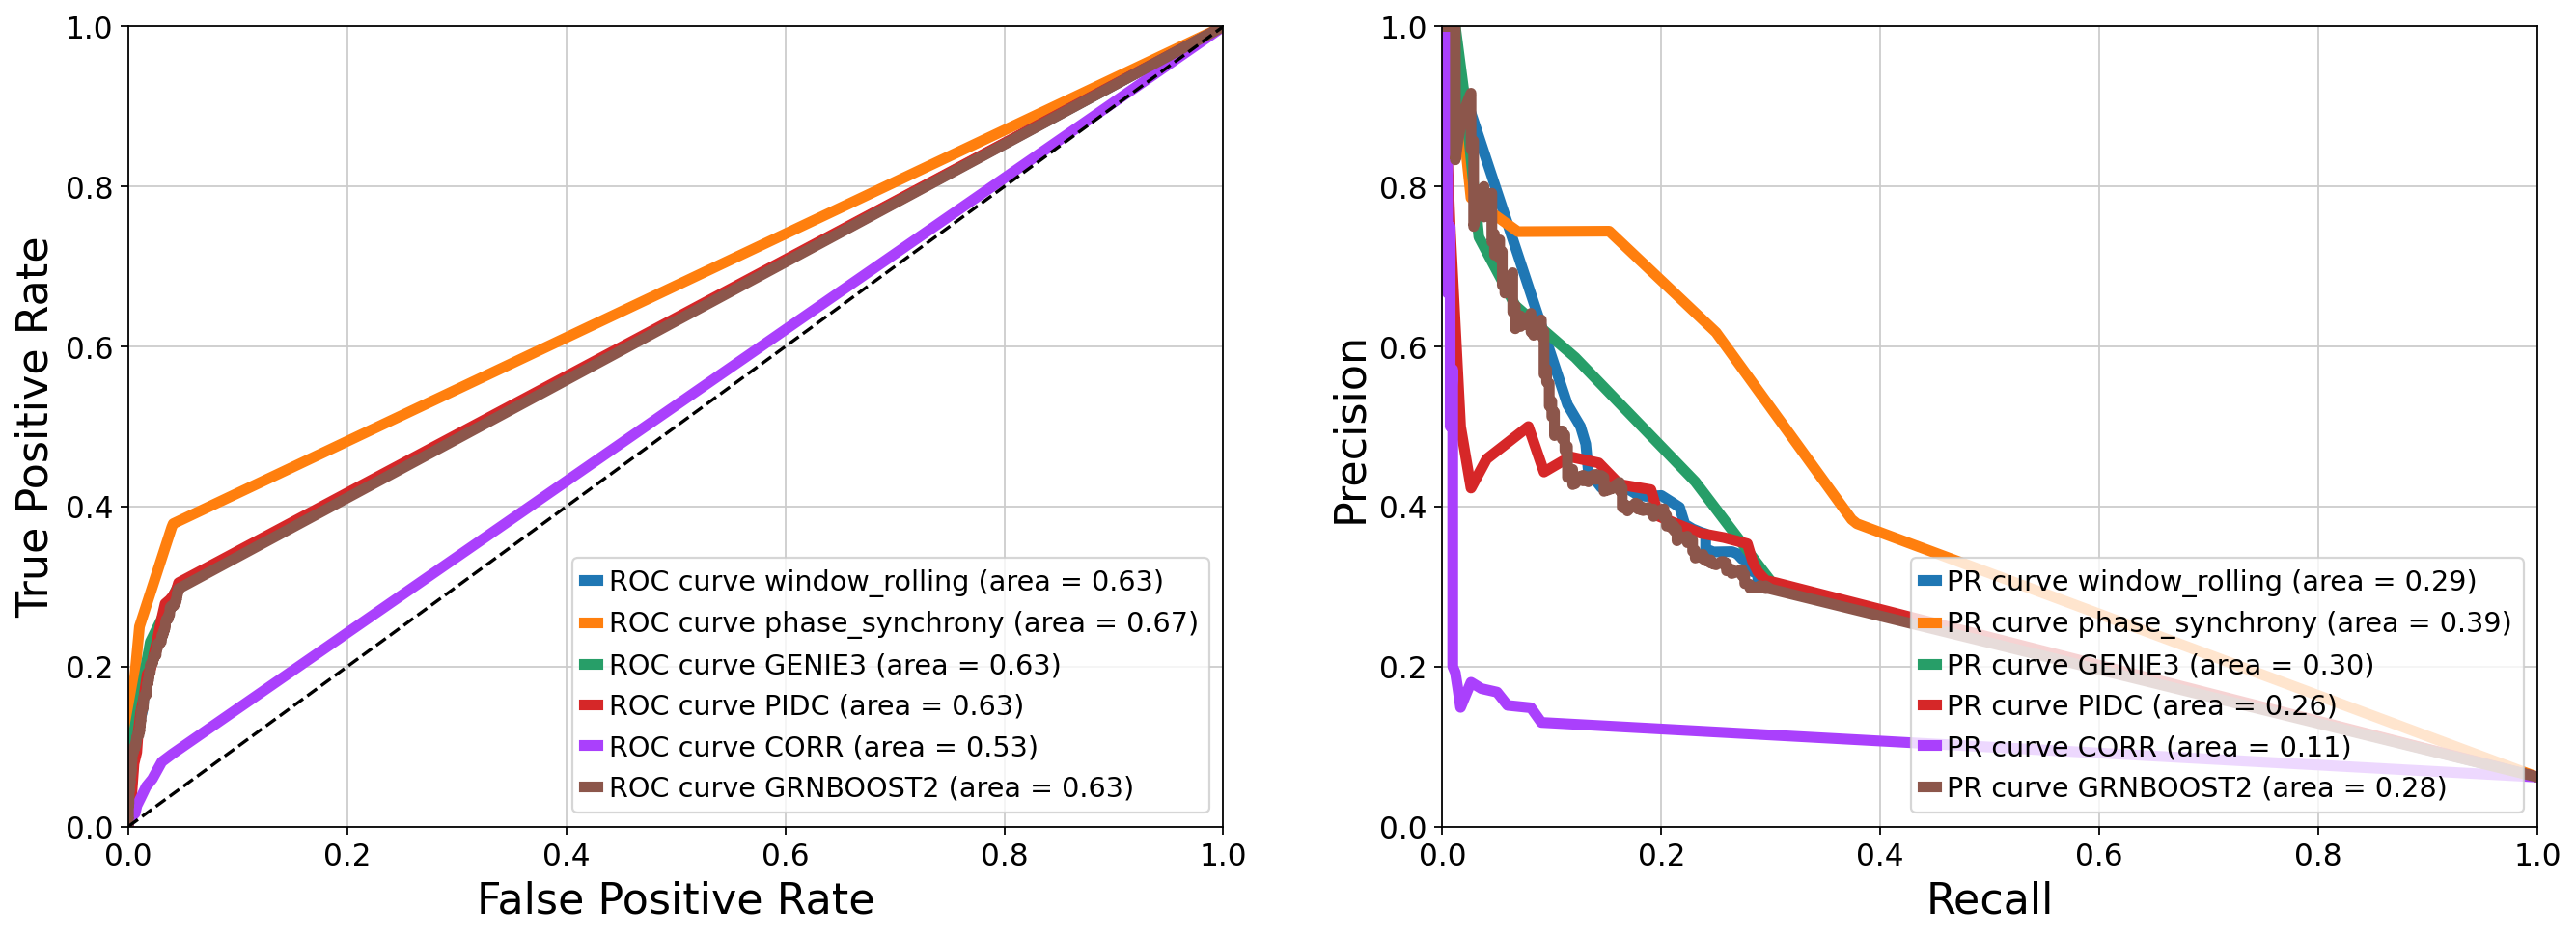

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 15))
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])

filename='test'
build_curves(ax1, dict_of_algs, 'ROC', filename, linewidth=5)
build_curves(ax2, dict_of_algs, 'PCR', filename, linewidth=5)

fig.savefig('result/test_consensus_confidence.pdf')

In [21]:
#build graph
stream_gne = gt.buildnet(stream_gne, key_links='phase_synchrony_links', top=420)

#calculate node centrality
stream_gne = gt.get_centrality(stream_gne)

#detect gene community
stream_gne = gt.detect_community(stream_gne)


graph added into NetAttrs
node centralities added into NetAttrs.
gene communities added into NetAttrs


### NetEnrich: Graph travel and supervised random walk
NetEnrich module integretes graph traversal techniques to expolre gene regulatory network. It includes **Breadth-first search**, **Depth-first search** and **Supervised random walk**. In this way, gene trigger paths indicating genes with hidden associations can be predicted. 

In [22]:
# Breadth-first search to explore gene network
bfs_path = list(gt.graph_traveral(stream_gne.NetAttrs['graph'], start='Gata1', threshold=3, method='bfs'))
# bfs_path

# #Supervised random walk
random_path = gt.random_walk(stream_gne, start = 'Mki67', supervisedby='degree', steps=5)
random_path

['Mki67', 'Rrm1', 'Rrm2', 'Mcm5', 'Mcm7', 'Pa2g4']

In [25]:
# dynamic_netShow(stream_gne, filename='result/stream_gne_consensus.html')

In [26]:
from __future__ import division, absolute_import, print_function
import sys
if sys.version_info < (3,):
    range = xrange
import os
from pylab import *  # for plotting
from numpy.random import *  # for random sampling
seed(42)

# We need to import the graph_tool module itself
from graph_tool.all import *

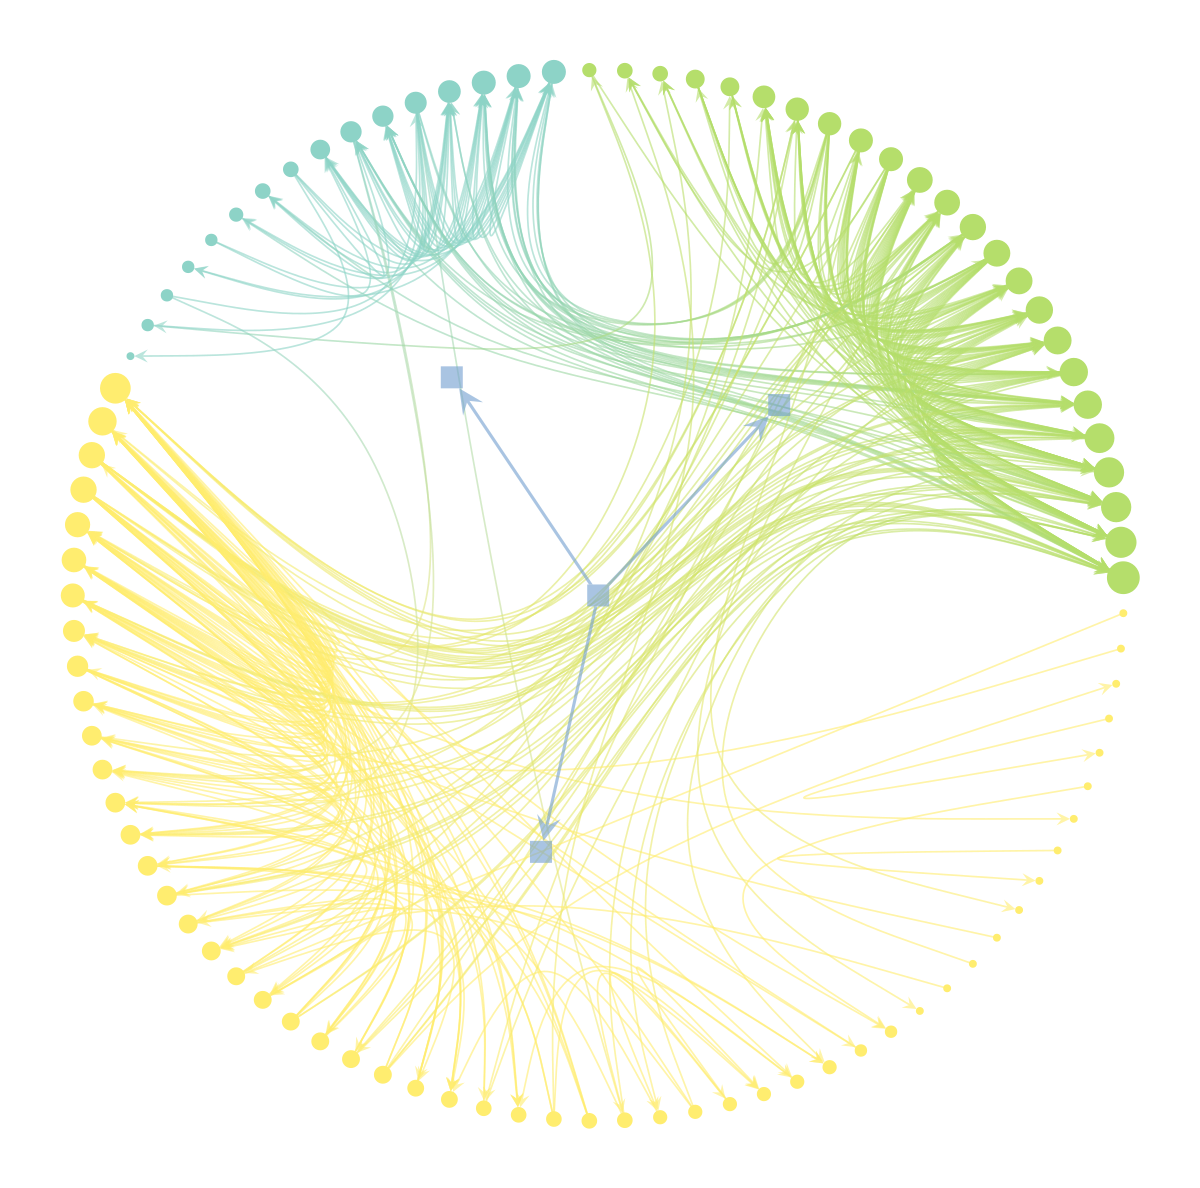

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3a08ec1208, at 0x7f3a08e39198>,
 <Graph object, directed, with 97 vertices and 96 edges, at 0x7f3a5c37f320>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3a5c37f320, at 0x7f3a08ec1518>)

In [51]:
import graph_tool.all as gt

edge_df = stream_gne.NetAttrs['phase_synchrony_links'].sort_values('weight', ascending=False).head(420)

g = Graph()
node_id = g.add_edge_list(edge_df.values, hashed=True, eprops=g.new_edge_property('float'))

g.vertex_properties['node_id'] = node_id
g.edge_properties['weight'] = g.new_edge_property('float')

state = gt.minimize_nested_blockmodel_dl(g)
gt.draw_hierarchy(state)


In [53]:
edge_df.values

array([['Mki67', 'Top2a', 0.8682242990654205],
       ['Mki67', 'Ccnb2', 0.8504672897196262],
       ['Tubb4b', 'Tubb5', 0.8476635514018691],
       ...,
       ['Mapre1', 'Tcp1', 0.794392523364486],
       ['Cct3', 'Rpn2', 0.794392523364486],
       ['Mcm2', 'Hat1', 0.794392523364486]], dtype=object)

### Plotting: Network Visualization 
Plotting module principlely provides a set of functions for visualization.

In [ ]:
#check gene expression in the indivisual cells along the pseudotime
import matplotlib
# matplotlib.rcParams['figure.figsize'] = (2, 2)

# fig = plt.figure(figsize=(20, 15))
# grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.2)
# ax1 = fig.add_subplot(grid[0, 0])
# ax2 = fig.add_subplot(grid[0, 1])


# geneCorrelation(stream_gne, gene=feature, 
#                         cell_clusterid=('S2', 'S1'), select_by='branch_id_alias',
#                         order_by='S1_pseudotime')

# geneCorrelation(stream_gne, gene=feature, 
#                         cell_clusterid=('S2', 'S1'), select_by='branch_id_alias',
#                         order_by='S1_pseudotime')



In [ ]:

cg = geneHeatmap(stream_gne, gene=feature, figsize=[5,5],
                    cell_clusterid=('S2', 'S1'), select_by='branch_id_alias', yticklabels=False,
                    order_by='S2_pseudotime', col_cluster=False)

cg.ax_row_dendrogram.set_visible(False)


In [ ]:
#gene correlation heatmap

gh.geneCorrelation(stream_gne, gene=feature,
                cell_clusterid=('S2', 'S1'), select_by='branch_id_alias',
                order_by='S1_pseudotime', xticklabels=False, yticklabels=False,
                save_as='result/gene_correlation.pdf', figsize=[5, 5])

In [ ]:
#save stream_gne as pickle 
# stream_gne.save_as('data/pyscnet_stream.pk')
# stream_gne = gnetdata.load_Gnetdata_object('data/pyscnet_stream.pk')